In [59]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import seaborn as sns

## Data preprocessing

In [60]:

train_dir = os.path.join('./train')
validation_dir = os.path.join('./val')
test_dir = os.path.join('./test')

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)


Found 21998 files belonging to 6 classes.


In [61]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2442 files belonging to 6 classes.


In [62]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           shuffle=False,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE)

Found 600 files belonging to 6 classes.


Show the first nine images and labels from the training set:

In [63]:
true_labels = []
for _, labels in test_dataset:
    true_labels.extend(labels.numpy())

# Print the true labels
print('True Labels:\n', true_labels)

True Labels:
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

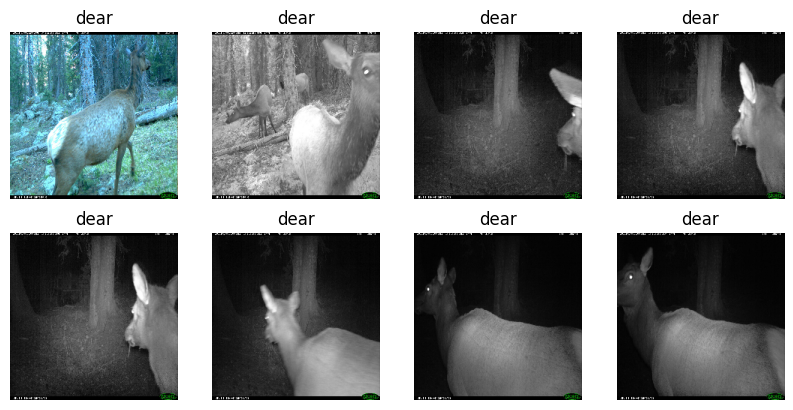

In [64]:
class_labels = ['dear', 'fox','leopard cat','porcupine','sumatran serow', 'wild boar']

plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(1):
    for i in range(8):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_labels[labels[i]])
        plt.axis("off")

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [65]:
val_batches = tf.data.experimental.cardinality(validation_dataset)



In [66]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 77
Number of test batches: 19


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. 

In [67]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

In [68]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomCrop(224, 224, seed=None, name=None),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2, fill_mode='nearest'),
    
])

Note: These layers are active only during training, when you call `Model.fit`. They are inactive when the model is used in inference mode in `Model.evaluate`, `Model.predict`, or `Model.call`.

Let's repeatedly apply these layers to the same image and see the result.

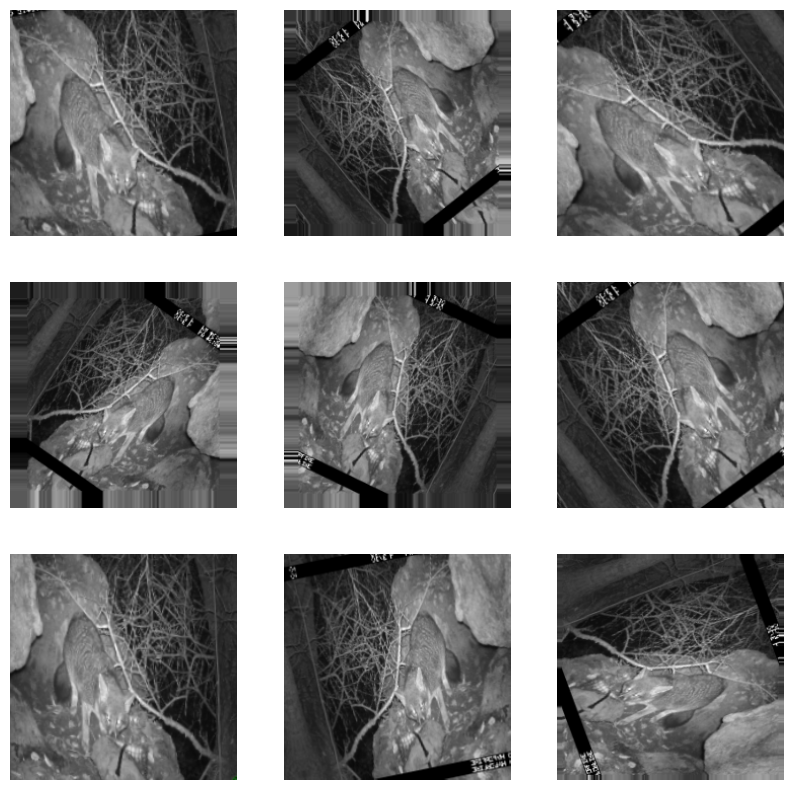

In [69]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [70]:
tf.keras.backend.clear_session()

### Rescale pixel values

## Create the Ensembel model

In [71]:
class WeightedAverageLayer(tf.keras.layers.Layer):
    def __init__(self, w1,w2,w3,**kwargs):
        super(WeightedAverageLayer, self).__init__(**kwargs)
        self.w1 = w1
        self.w2 = w2
        self.w3 = w3
        

    def call(self, inputs):
        return (self.w1 * inputs[0] + self.w2 * inputs[1] + self.w3 * inputs[2])

In [72]:
# Create the base model from the pre-trained model Resnet50
IMG_SHAPE = IMG_SIZE + (3,)



np.set_printoptions(suppress=True)

# Load the model
keras_model = tf.keras.models.load_model('models/MobileNetV2/MobileNetV2/MobileNetV2.h5', compile=False)
keras_model._name = 'model1'
keras_model2 = tf.keras.models.load_model('models/DenseNet121/DenseNet121/DenseNet121.h5', compile=False)
keras_model2._name = 'model2'
keras_model3 = tf.keras.models.load_model('models/EfficientNetV2B0/EfficientNetV2B0/EfficientNetV2B0.h5', compile=False)
keras_model3._name = 'model3'


models = [keras_model, keras_model2, keras_model3]
#model_input = tf.keras.Input(shape=(125, 125, 3))
model_input = tf.keras.Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = WeightedAverageLayer(0.1,0.7,0.2)(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)  





In [73]:

import tensorflow as tf
import os

# Set the number of parallel execution units
NUM_PARALLEL_EXEC_UNITS = 8

# Configuring TensorFlow Session
config = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=NUM_PARALLEL_EXEC_UNITS,
    inter_op_parallelism_threads=1
)
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))


# MKL and OpenMP
os.environ["OMP_NUM_THREADS"] = str(NUM_PARALLEL_EXEC_UNITS)
os.environ["KMP_BLOCKTIME"] = "1"
os.environ["KMP_SETTINGS"] = "1"
os.environ["KMP_AFFINITY"] = "granularity=fine,verbose,compact,1"

In [74]:
model_name = "EnsembleModel"

models_dir = os.path.join('./models')
model_dir = os.path.join(models_dir, model_name)
model_save_dir = os.path.join(model_dir, model_name)
model_save_path = os.path.join(model_save_dir, model_name + "_base.h5")


if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

In [75]:

from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, CSVLogger
# Save the model with best weights
top_layers_file_path = os.path.join(model_save_dir, model_name + "_top_layers.h5")

# Save the model after every epoch.
checkpoint = ModelCheckpoint(top_layers_file_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
# Save the TensorBoard logs.
tb = TensorBoard(log_dir='./logs', write_graph=True, update_freq='batch')
# Stop training when a monitored metric has stopped improving.
early = EarlyStopping(monitor="loss", mode="min", patience=5)
# Save the CSV logger
csv_logger = CSVLogger('./logs/ensembel-log.csv', append=True)

In [76]:
# Check if GPU is available
import tensorflow as tf

devices = tf.config.list_physical_devices('GPU')
print("GPU Devices:", devices)

GPU Devices: []


In [77]:


from datetime import datetime


def accuracy_loss_plot(history, model_config):
    epochs = history.epoch
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    run_epochs = len(epochs)

    f = 1
    save_epochs = [epochs[i] for i in range(0, run_epochs, f)]
    save_tr_acc = [tr_acc[i] for i in range(0, run_epochs, f)]
    save_tr_loss = [tr_loss[i] for i in range(0, run_epochs, f)]
    save_val_acc = [val_acc[i] for i in range(0, run_epochs, f)]
    save_val_loss = [val_loss[i] for i in range(0, run_epochs, f)]

    # Create a figure and axis
    fig, ax1 = plt.subplots()

    fig.set_figheight(12)
    fig.set_figwidth(24)

    # Plot accuracy lines
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy', color='black')
    ax1.plot(save_epochs, save_tr_acc, color='#800000', marker='o', label='Training Accuracy')
    ax1.plot(save_epochs, save_val_acc, color='#000075', marker='x', label='Validation Accuracy')
    # ax1.set_xticklabels(save_epochs, rotation=90)

    # Create a second y-axis for loss lines
    ax2 = ax1.twinx()  # Share the same x-axis
    ax2.set_ylabel('Loss', color='black')
    ax2.plot(save_epochs, save_tr_loss, color='#3cb44b', marker='s', label='Training Loss')
    ax2.plot(save_epochs, save_val_loss, color='#f58231', marker='^', label='Validation Loss')
    ax2.tick_params(axis='y', labelcolor='black')

    # Add a legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='best')

    # Set a title
    plt.title('Accuracy and Loss Over Epochs')

    accuracy_matrices_path = os.path.join(os.getcwd(), './metrics/accuracy_matrices')

    curr_datetime = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
    filename = f'{model_name.lower()}-{model_config}-training_metrics_plot-{format(curr_datetime)}.png'

    if not os.path.exists(accuracy_matrices_path):
        os.makedirs(accuracy_matrices_path)

    # Save the plot to the specified folder
    destination = os.path.join(accuracy_matrices_path, filename)
    plt.savefig(destination, bbox_inches='tight')

### Compile the model

In [78]:
base_learning_rate = 0.0001

ensemble_model. compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), metrics=['accuracy', 'top_k_categorical_accuracy'], loss='sparse_categorical_crossentropy')


### Train the model


In [79]:
initial_epochs = 10
history = ensemble_model.fit(train_dataset, 
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


688/688 [==============================] - 7705s 11s/step - loss: 0.1433 - accuracy: 0.9604 - top_k_categorical_accuracy: 0.8574 - val_loss: 0.1154 - val_accuracy: 0.9840 - val_top_k_categorical_accuracy: 0.4631
Epoch 2/10
688/688 [==============================] - 7482s 11s/step - loss: 0.1122 - accuracy: 0.9687 - top_k_categorical_accuracy: 0.8920 - val_loss: 0.0993 - val_accuracy: 0.9848 - val_top_k_categorical_accuracy: 0.7781
Epoch 3/10
688/688 [==============================] - 8240s 12s/step - loss: 0.0877 - accuracy: 0.9767 - top_k_categorical_accuracy: 0.8888 - val_loss: 0.0977 - val_accuracy: 0.9722 - val_top_k_categorical_accuracy: 0.8010
Epoch 4/10
688/688 [==============================] - 8512s 12s/step - loss: 0.0619 - accuracy: 0.9822 - top_k_categorical_accuracy: 0.8611 - val_loss: 0.0683 - val_accuracy: 0.9779 - val_top_k_categorical_accuracy: 0.8198
Epoch 5/10
688/688 [==============================] - 9077s 13s/step - loss: 0.0591 - accuracy: 0.9801 - top_k_categori

In [80]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print(acc)
print(val_acc)


[0.9604054689407349, 0.9686789512634277, 0.976725161075592, 0.9822256565093994, 0.9800891280174255, 0.9811801314353943, 0.9862260222434998, 0.9853168725967407, 0.9876352548599243, 0.9863169193267822]
[0.9840294718742371, 0.9848484992980957, 0.9721539616584778, 0.977886974811554, 0.9795249700546265, 0.9438984394073486, 0.9717444777488708, 0.9868959784507751, 0.9881244897842407, 0.9950860142707825]


In [81]:
#evaluating the model
accuracy0 = ensemble_model.evaluate(test_dataset)

19/19 [==============================] - 101s 5s/step - loss: 0.3299 - accuracy: 0.9317 - top_k_categorical_accuracy: 0.9633


In [82]:

print("initial accuracy: {:.2f}".format(accuracy0[1]))

initial accuracy: 0.93


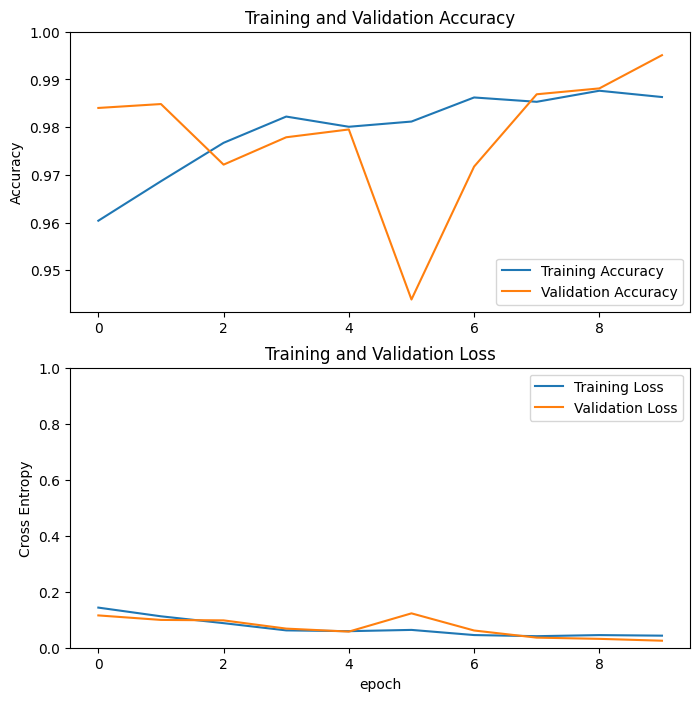

In [83]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [84]:
# Get the predictions for the test data
predictions = ensemble_model.predict(test_dataset)

19/19 [==============================] - 128s 6s/step


Predicted Classes:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 1 0 5 0 5
 5 5 5 5 5 5 5 5 0 2 1 0 5 5 5 5 1 1 5 5 5 1 1 1 1 1 2 2 5 1 1 1 1 1 5 5 5
 1 5 5 1 2 2 1 2 0 0 5 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 

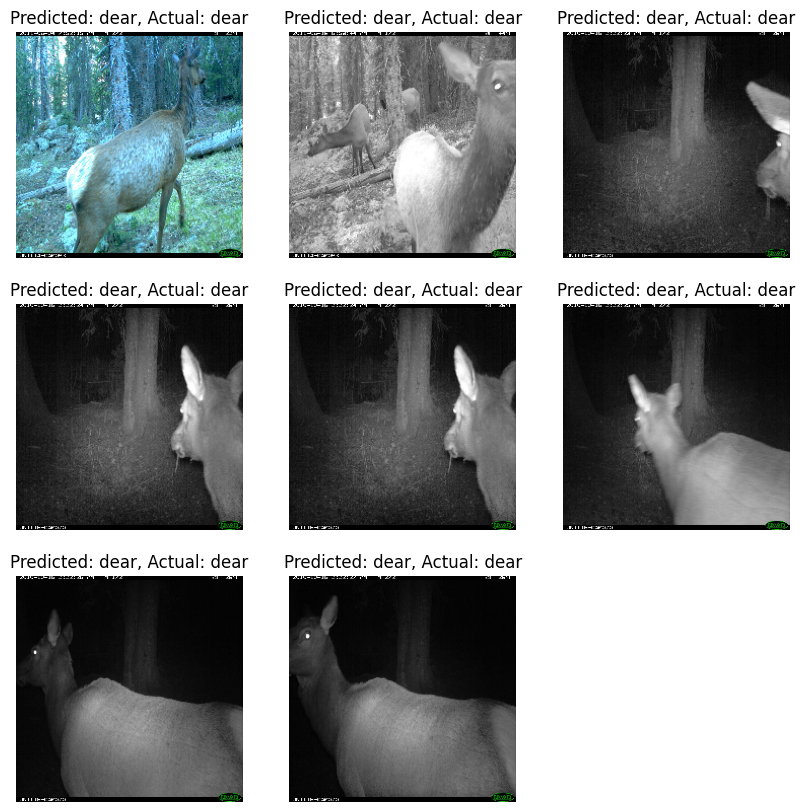

In [85]:

# Apply argmax to get the predicted class
predicted_classes = tf.argmax(predictions, axis=1)


print('Predicted Classes:\n', predicted_classes.numpy())
print('True Classes:\n', np.array(true_labels))

plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(1):
  for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f'Predicted: {class_labels[predicted_classes[i]]}, Actual: {class_labels[labels[i]]}')
    plt.axis("off")


In [86]:

from sklearn.metrics import f1_score, precision_score, recall_score,accuracy_score


acc = accuracy_score(true_labels, predicted_classes)
precision = precision_score(true_labels, predicted_classes, average='macro')
recall = recall_score(true_labels, predicted_classes, average='macro')
f1 = f1_score(true_labels, predicted_classes, average='macro')

metrics_path = os.path.join(os.getcwd(), './metrics/metric_values')
curr_datetime = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
filename = f'{model_name}-metrics-{format(curr_datetime)}.txt'

if not os.path.exists(metrics_path):
    os.makedirs(metrics_path)

file_path = os.path.join(metrics_path, filename)
with open(file_path, 'w') as file:
    file.write(f'Accuracy: {acc:.3f}\n')
    file.write(f'Precision: {precision:.3f}\n')
    file.write(f'Recall: {recall:.3f}\n')
    file.write(f'F1 Score: {f1:.3f}\n')
  
print(f'Accuracy: {acc:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1 Score: {f1:.3f}')

Accuracy: 0.932
Precision: 0.941
Recall: 0.932
F1 Score: 0.927


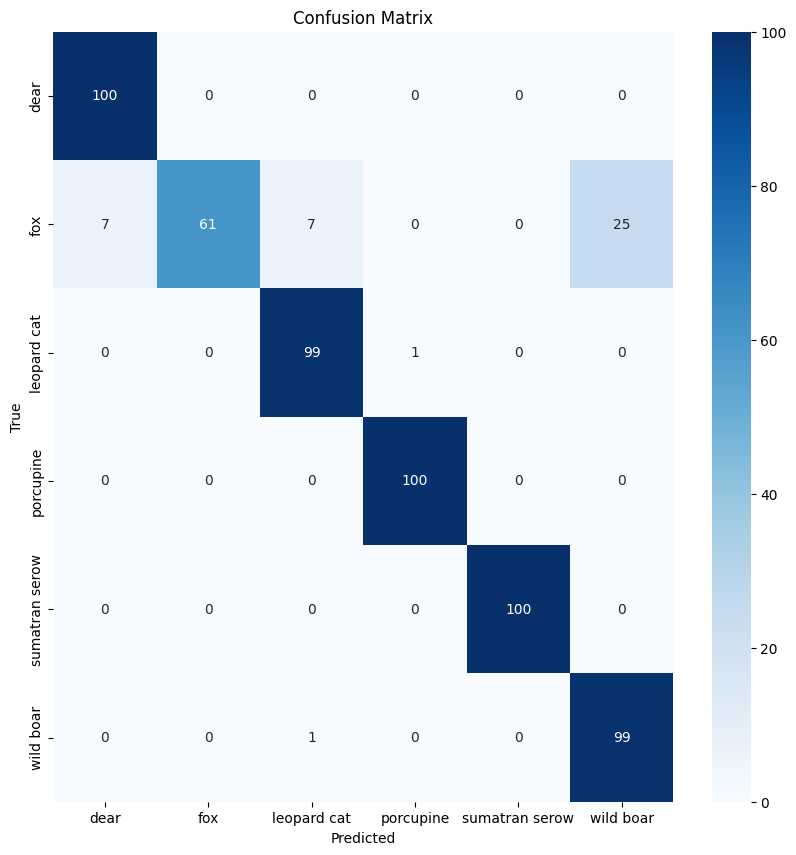

In [87]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_matrix_res = confusion_matrix(true_labels, predicted_classes)


plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix_res, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

confusion_matrix_path = os.path.join(os.getcwd(), './metrics_ensembel/confusion_matrices')
curr_datetime = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
filename = f'{model_name}-confusion_matrix-{format(curr_datetime)}.png'

if not os.path.exists(confusion_matrix_path):
    os.makedirs(confusion_matrix_path)

# Save the plot to the specified folder
save_path = os.path.join(confusion_matrix_path, filename)
plt.savefig(save_path, bbox_inches='tight')

In [88]:
from datetime import datetime
from itertools import cycle
from sklearn.calibration import label_binarize
from sklearn.metrics import auc, roc_curve

model_name = 'EnsembleModel'
num_labels=6

def get_ROC_AUC(y_pred, y_target):
    # Binarize the labels
    n_classes = num_labels
    true_labels_bin = label_binarize(y_target, classes=range(n_classes))
    predicted_labels_bin = label_binarize(y_pred, classes=range(n_classes))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        print()
        fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predicted_labels_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    return fpr, tpr, roc_auc

def save_ROC_AUC(fpr, tpr, roc_auc):
    n_classes = num_labels

    # Plot ROC curves for each class
    plt.figure(figsize=(12, 12))

    hex_colors = [
        "#FF0000",  # Red
        "#00FF00",  # Green
        "#0000FF",  # Blue
        "#FFFF00",  # Yellow
        "#FF00FF",  # Magenta
        "#00FFFF",  # Cyan
        "#FFA500",  # Orange
        "#FF4500",  # OrangeRed
        "#FFD700",  # Gold
        "#8A2BE2",  # BlueViolet
        "#7FFF00",  # Chartreuse
        "#DC143C",  # Crimson
        "#48D1CC",  # MediumTurquoise
        "#2E8B57",  # SeaGreen
        "#800080",  # Purple
        "#ADFF2F",  # GreenYellow
        "#FF1493",  # DeepPink
        "#9370DB",  # MediumPurple
        "#8B4513",  # SaddleBrown
        "#20B2AA",  # LightSeaGreen
        "#8B008B",  # DarkMagenta
        "#FF6347",  # Tomato
        "#556B2F",  # DarkOliveGreen
        "#6B8E23",  # OliveDrab
        "#BDB76B",  # DarkKhaki
        "#808080",  # Gray
        "#DAA520",  # GoldenRod
    ]

    colors = cycle(hex_colors)  # Adjust as needed for your number of classes

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                    label=f'{class_labels[i]} (AUC = {roc_auc[i]:.3f})')

    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')  # Diagonal line for reference
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve and AUC')
    plt.legend(loc='lower right')

    roc_auc_path = os.path.join(os.getcwd(), './metrics/roc_auc')
    curr_datetime = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
    filename = f'{model_name.lower()}-roc_auc-{format(curr_datetime)}.png'

    if not os.path.exists(roc_auc_path):
        os.makedirs(roc_auc_path)

    # Save the plot to the specified folder
    save_path = os.path.join(roc_auc_path, filename)
    plt.savefig(save_path, bbox_inches='tight')

In [89]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_classes.numpy(),target_names = class_labels))

                precision    recall  f1-score   support

          dear       0.93      1.00      0.97       100
           fox       1.00      0.61      0.76       100
   leopard cat       0.93      0.99      0.96       100
     porcupine       0.99      1.00      1.00       100
sumatran serow       1.00      1.00      1.00       100
     wild boar       0.80      0.99      0.88       100

      accuracy                           0.93       600
     macro avg       0.94      0.93      0.93       600
  weighted avg       0.94      0.93      0.93       600



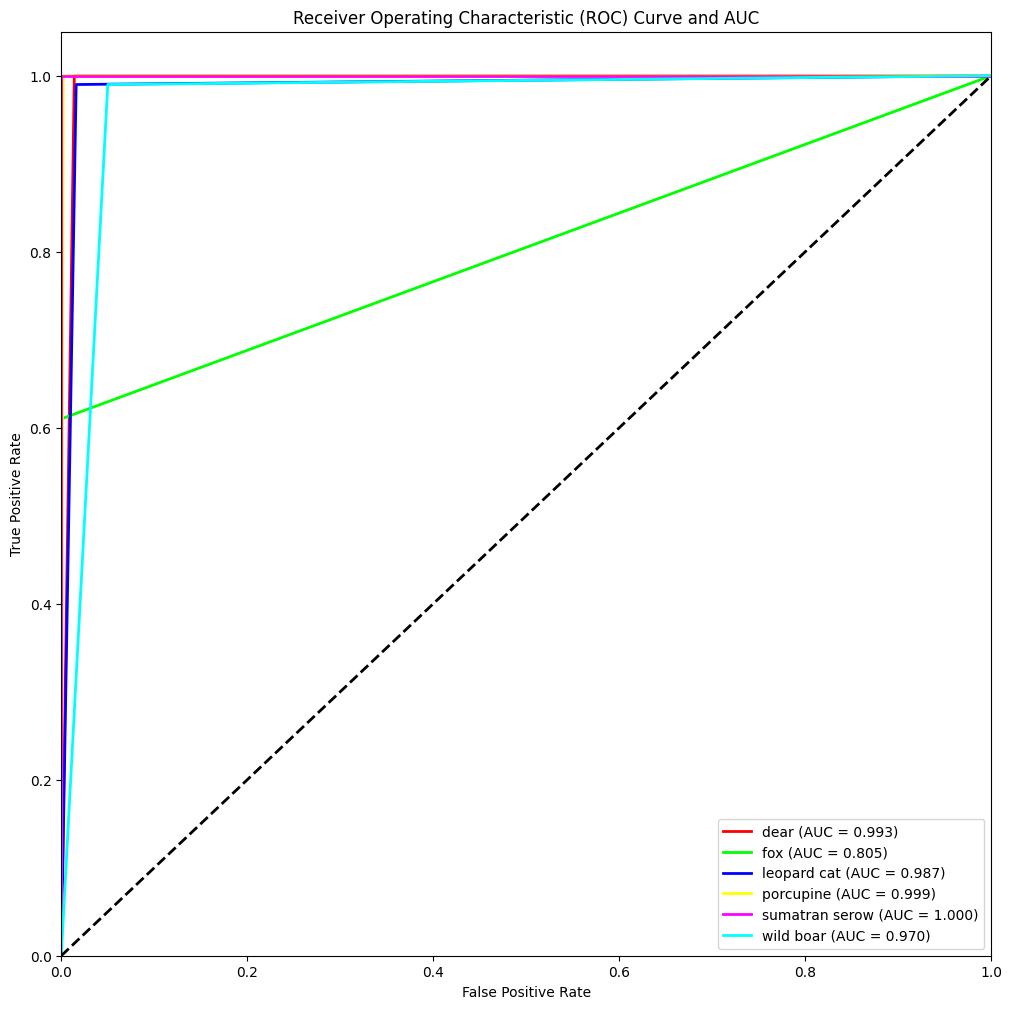

In [90]:
fpr, tpr, roc_auc = get_ROC_AUC(predicted_classes, true_labels)
save_ROC_AUC(fpr, tpr, roc_auc)

In [91]:
#save weights of the trained model to the specified folder
ensemble_model.save_weights(os.path.join(model_save_dir, model_name + "_weights.h5"))

In [92]:
#save model to the specified folder
ensemble_model.save(os.path.join(model_save_dir, model_name + ".h5"))

c:\Users\sumeela\FYP\Animal-Classification-at-Edge\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


ValueError: Unable to synchronously create dataset (name already exists)

In [ ]:
#convert to tflite and save to new folder called tflite_models
converter = tf.lite.TFLiteConverter.from_keras_model(ensemble_model)
tflite_model = converter.convert()

tflite_models_dir = os.path.join(os.getcwd(), 'tflite_models')
tflite_model_dir = os.path.join(tflite_models_dir, model_name)

if not os.path.exists(tflite_model_dir):
    os.makedirs(tflite_model_dir)

tflite_model_save_path = os.path.join(tflite_model_dir, model_name + ".tflite")
with open(tflite_model_save_path, 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\sumeela\AppData\Local\Temp\tmp9v6cf1p9\assets


INFO:tensorflow:Assets written to: C:\Users\sumeela\AppData\Local\Temp\tmp9v6cf1p9\assets


In [ ]:
# import tensorflow as tf
# import numpy as np
# from tensorflow.keras.preprocessing import image

# # Open image and resize
# img_path = 'geranimo-AX9sJ-mPoL4-unsplash.jpg'
# img = image.load_img(img_path, target_size=(224, 224))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# # img_array /= 255.0  # Normalize pixel values to be between 0 and 1

# # Load the model
# model = tf.keras.models.load_model('models/MobileNetV2/MobileNetV2/MobileNetV2.h5')

# # Make predictions
# predictions = model.predict(img_array)
# print(predictions)

# # Get the index of the highest probability class
# predicted_class_index = np.argmax(predictions, axis=1)
# print(predicted_class_index)

# # You might have a class_names list, and you can print the predicted class name
# # print(class_names[predicted_class_index[0]])


1/1 [==============================] - 3s 3s/step
[[0.10995597 0.27621388 0.0692147  0.00668932 0.10393332 0.43399286]]
[5]


In [ ]:

# from sklearn.metrics import classification_report


# #load tf lite model and want to calculate accuracy of the compressed model
# interpreter = tf.lite.Interpreter(model_path='./tflite_models/MobileNetV2/MobileNetV2.tflite')

# true_labels = true_labels
# predicted_labels = []

# for images, labels in test_dataset:
#     for image in images:
#         image = tf.expand_dims(image, axis=0)
#         interpreter.allocate_tensors()
#         interpreter.set_tensor(interpreter.get_input_details()[0]['index'], image)
#         interpreter.invoke()
#         preds = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])
#         preds = np.argmax(preds, axis=1)
#         predicted_labels.extend(preds)

# print(classification_report(true_labels, predicted_labels, target_names=class_labels))




INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


                precision    recall  f1-score   support

          dear       0.98      0.90      0.94       100
           fox       0.95      0.40      0.56       100
   leopard cat       0.98      0.99      0.99       100
     porcupine       0.99      1.00      1.00       100
sumatran serow       0.91      1.00      0.95       100
     wild boar       0.64      0.98      0.77       100

      accuracy                           0.88       600
     macro avg       0.91      0.88      0.87       600
  weighted avg       0.91      0.88      0.87       600

